# **Improving CNN autoencoders for removing occlusions from gaussian blurs**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
# Creating Gaussian Blurs with different widths
nGauss=1000
imgSize=91

x=np.linspace(-4,4,imgSize) 
X,Y=np.meshgrid(x,x)

# the two widths (arbitary units {a.u.})
widths=np.linspace(2,20,nGauss)

# initialize tensors containing images and labels
images=tr.zeros(2*nGauss,1,imgSize,imgSize)
images_original=tr.zeros(2*nGauss,1,imgSize,imgSize)

for i in range(2*nGauss):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro-> random offset
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*widths[i%2]**2))

    images_original[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)
    
    # and add noise
    G=G+np.random.randn(imgSize,imgSize)/5

    # add a random bar randomly
    i1=np.random.choice(np.arange(2,28))
    i2=np.random.choice(np.arange(2,6))

    if np.random.randn()>0:
        G[i1:i1+i2,]=1
    else:
        G[:,i1:i1+i2]=1

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)

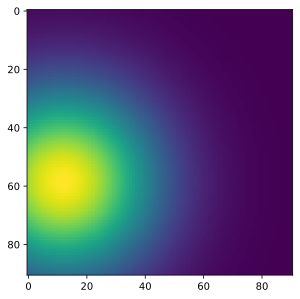

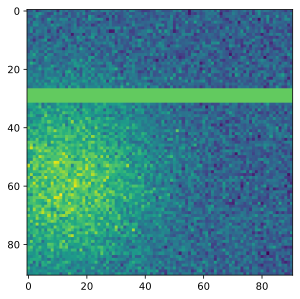

In [7]:
plt.imshow(images_original[0,0,:,:])
plt.show()
plt.imshow(images[0,0,:,:])
plt.show()

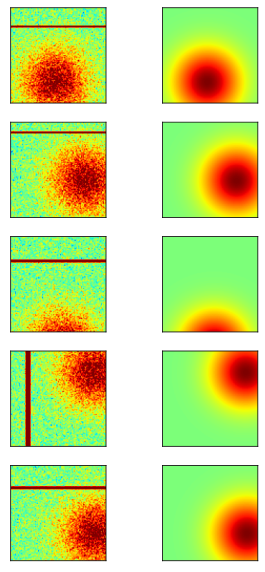

In [11]:
# visualize some images
fig,axs=plt.subplots(5,2,figsize=(5,10))


for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nGauss)
    if i%2==0:
        G=np.squeeze(images[whichpic,:,:])
        OG=np.squeeze(images_original[whichpic,:,:])
        ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    else:
        ax.imshow(OG,vmin=-1,vmax=1,cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [12]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,images_original,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1, 91, 91])


In [14]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [15]:
# Create the DL model
def createNet(lr=0.001):
    input_img_channels=1
    convOutChannels=[6,4]
    imgSize=(91,91)
    kernelSize=(3,3)
    strideSize=(1,1)
    paddingSize=(1,1)
    poolSize=(2,2)
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### ENCODER: 

            # conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.conv1=nn.Conv2d(input_img_channels,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            
            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            ### DECODER:

            # trans-conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.t_conv1=nn.ConvTranspose2d(convOutChannels[1],convOutChannels[0],kernelSize,stride=poolSize)

            # trans-conv 2
            self.t_conv2=nn.ConvTranspose2d(convOutChannels[0],input_img_channels,kernelSize,stride=poolSize)



        def forward(self,x):
            ### Encoder

            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            pool1=F.avg_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(pool1))  
            
            # Latent/code/bottleneck layer output
            latentAct=F.avg_pool2d(conv2act,poolSize)
            
            ### Decoder

            # first trans-conv-pool set
            tconv1act=F.relu(self.t_conv1(latentAct))

            # second trans-conv-pool set
            output=self.t_conv2(tconv1act)

            return output,conv1act,conv2act,latentAct,tconv1act

    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.MSELoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [16]:
# test the model with one batch
net,lossfun,optimizer=createNet(25)

X,y = next(iter(train_loader))
yHat,conv1act,conv2act,latentAct,tconv1act=net(X)

# check size of output
print('\nPredicted Category')
print(yHat.shape)
print('\nFeature maps after conv1')
print(conv1act.shape)
print('\nFeature maps after conv2')
print(conv2act.shape)

print('\nFeature Maps of latent layer')
print(latentAct.shape)
print('\nFeature maps after t-conv1')
print(tconv1act.shape)


# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)


Predicted Category
torch.Size([32, 1, 91, 91])

Feature maps after conv1
torch.Size([32, 6, 91, 91])

Feature maps after conv2
torch.Size([32, 4, 45, 45])

Feature Maps of latent layer
torch.Size([32, 4, 22, 22])

Feature maps after t-conv1
torch.Size([32, 6, 45, 45])
 
Loss: 
tensor(0.1510, grad_fn=<MseLossBackward0>)


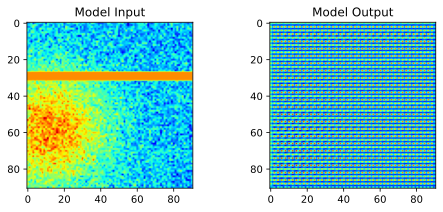

In [17]:
# lets see how they look
fig,ax=plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(tr.squeeze(images[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model Input')
ax[1].imshow(tr.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model Output')
plt.show()

In [19]:
# count the total number of parameters in the model
# send the model to the GPU
net.to(device)
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
   ConvTranspose2d-3            [-1, 6, 45, 45]             222
   ConvTranspose2d-4            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Params size (MB): 0.00
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


In [20]:
# Create a function that trains the model

def trainModel(n_epochs=100):
    # create a new model
    net,lossfun,optimizer=createNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        
        print(f'{epochi+1}/{n_epochs} complete!')
    # end of epochs

    # function output
    return trainLoss,testLoss,net

In [21]:
# Run the model and show the results
trainLoss,testLoss,net=trainModel()

1/100 complete!
2/100 complete!
3/100 complete!
4/100 complete!
5/100 complete!
6/100 complete!
7/100 complete!
8/100 complete!
9/100 complete!
10/100 complete!
11/100 complete!
12/100 complete!
13/100 complete!
14/100 complete!
15/100 complete!
16/100 complete!
17/100 complete!
18/100 complete!
19/100 complete!
20/100 complete!
21/100 complete!
22/100 complete!
23/100 complete!
24/100 complete!
25/100 complete!
26/100 complete!
27/100 complete!
28/100 complete!
29/100 complete!
30/100 complete!
31/100 complete!
32/100 complete!
33/100 complete!
34/100 complete!
35/100 complete!
36/100 complete!
37/100 complete!
38/100 complete!
39/100 complete!
40/100 complete!
41/100 complete!
42/100 complete!
43/100 complete!
44/100 complete!
45/100 complete!
46/100 complete!
47/100 complete!
48/100 complete!
49/100 complete!
50/100 complete!
51/100 complete!
52/100 complete!
53/100 complete!
54/100 complete!
55/100 complete!
56/100 complete!
57/100 complete!
58/100 complete!
59/100 complete!
60/100

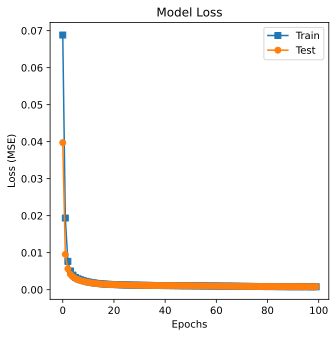

In [22]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(trainLoss,'s-',label="Train")
ax.plot(testLoss,'o-',label="Test")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Model Loss')
ax.legend()

plt.show()

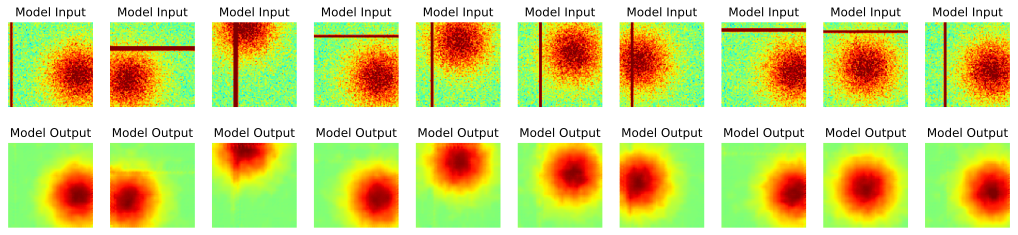

In [24]:
# visualize some images
X,y=next(iter(test_loader))
yHat=net(X)[0]

fig,axs=plt.subplots(2,10,figsize=(18,4))

for i in range(10):
    G=tr.squeeze(X[i,0,:,:]).detach()
    O=tr.squeeze(yHat[i,0,:,:]).detach()
    
    axs[0,i].imshow(G,vmin=-1,vmax=1,cmap="jet")
    axs[0,i].axis('off')How can
    axs[0,i].set_title('Model Input')
    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap="jet")
    axs[1,i].axis('off')
    axs[1,i].set_title('Model Output')

plt.show()

**Observations:**
* We have been able to remove the occluding bars but the model is smoothing the output, we can preserve high frequency component by increasing the latent layer.  
* For labels we had used non-noisy gaussian blurs hence they are even more blurred, if we had used the noisy blurs it wouldn't have been so blurred.
* CNN autoencoders are very powerful for denoising images

**Additional Explorations**

In [27]:
# 1) The network does OK but there are still residual occlusion artifacts. Perhaps there weren't enough training examples? If you would increase nGauss from 1000 to 10000, would that mean that the model trains on 10x as many examples? 
# (Hint: the answer is No, but you need to figure out why!) How can you adapt the model so that it trains on more unique sample images?
# With 1000 images and 100 epochs of training itself the loss is already minimum (less then 0.5)for both train and test set of images.
# Need to figure out on how to adapt the model so that it trains on more unique sample images

# 2) The bars appear in a random location for each image. Would the network still learn to remove the occlusions if the  bars appeared in the exact same location with the same thickness? Change the stimulus generation code to implement this. You can still keep the randomization to horizontal or vertical, but remove the random selection of thickness and location.
# If bars appeared in the same location in the image, it should be much better as the model now can come up with a fixed-definite and better filter for the problem (not tested - but intuitive)